In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install rouge nltk sacrebleu bert_score

In [22]:
import pandas as pd
from bert_score import score
import matplotlib.pyplot as plt
from bert_score import plot_example

import tensorflow as tf
from tensorflow.keras import backend as K
import nltk
import sacrebleu
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
import numpy as np

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
df = pd.read_excel('./drive/MyDrive/SAE/stat.xlsx')
print(df.columns)

Index(['Question', 'GPT2-Large', 'Without_LoRA_Model_V1', 'LoRA_Model_V1',
       'LoRA_Model_V2', 'ChatGPT', 'Reference', 'new'],
      dtype='object')


In [24]:
def caractere_remove(text):
  text = text.replace("\n", " ")
  text = text.replace("\t", " ")
  return text

In [25]:
def calculate_metrics(generated_texts, reference_texts):
    # Initialize metrics
    bleu_scores = []
    rouge_scores = []
    meteor_scores = []

    # Initialize ROUGE scorer
    rouge = Rouge()

    for gen_text, ref_text in zip(generated_texts, reference_texts):
        # Preprocess texts: Tokenize for METEOR
        gen_tokens = nltk.word_tokenize(gen_text)
        ref_tokens = nltk.word_tokenize(ref_text)

        # Calculate BLEU score
        bleu_score = sacrebleu.raw_corpus_bleu([gen_text], [[ref_text]], .01).score
        bleu_scores.append(bleu_score)

        # Calculate ROUGE scores
        rouge_score = rouge.get_scores(gen_text, ref_text)[0]
        rouge_scores.append(rouge_score)

        # Calculate METEOR score
        meteor_score_value = meteor_score([ref_tokens], gen_tokens)
        meteor_scores.append(meteor_score_value)

    return bleu_scores, rouge_scores, meteor_scores


In [26]:
def calculate_mean_scores(bleu_scores, rouge_scores, meteor_scores):
    # Calculate the mean for BLEU and METEOR
    mean_bleu_score = np.mean(bleu_scores)
    mean_meteor_score = np.mean(meteor_scores)

    # Initialize variables to calculate the mean of ROUGE scores
    rouge_1_recall, rouge_1_precision, rouge_1_fmeasure = [], [], []
    rouge_2_recall, rouge_2_precision, rouge_2_fmeasure = [], [], []
    rouge_l_recall, rouge_l_precision, rouge_l_fmeasure = [], [], []

    # Extract ROUGE scores
    for scores in rouge_scores:
        rouge_1_recall.append(scores['rouge-1']['r'])
        rouge_1_precision.append(scores['rouge-1']['p'])
        rouge_1_fmeasure.append(scores['rouge-1']['f'])

        rouge_2_recall.append(scores['rouge-2']['r'])
        rouge_2_precision.append(scores['rouge-2']['p'])
        rouge_2_fmeasure.append(scores['rouge-2']['f'])

        rouge_l_recall.append(scores['rouge-l']['r'])
        rouge_l_precision.append(scores['rouge-l']['p'])
        rouge_l_fmeasure.append(scores['rouge-l']['f'])

    # Calculate the mean of ROUGE scores
    mean_scores = {
        'bleu': mean_bleu_score,
        'meteor': mean_meteor_score,
        'rouge-1': {
            'recall': np.mean(rouge_1_recall),
            'precision': np.mean(rouge_1_precision),
            'fmeasure': np.mean(rouge_1_fmeasure),
        },
        'rouge-2': {
            'recall': np.mean(rouge_2_recall),
            'precision': np.mean(rouge_2_precision),
            'fmeasure': np.mean(rouge_2_fmeasure),
        },
        'rouge-l': {
            'recall': np.mean(rouge_l_recall),
            'precision': np.mean(rouge_l_precision),
            'fmeasure': np.mean(rouge_l_fmeasure),
        },
    }

    return mean_scores

# Example usage with your models' scores
# mean_scores = calculate_mean_scores(bleu_scores, rouge_scores, meteor_scores)
# print(mean_scores)

In [27]:
def visualize_mean_scores(mean_scores):
    """
    Visualizes the mean scores of BLEU, METEOR, and ROUGE metrics.

    Parameters:
    - mean_scores: A dictionary containing the mean scores for BLEU, METEOR, and ROUGE metrics.
    """
    # Create lists for metrics and their corresponding mean values
    metrics = ['BLEU', 'METEOR', 'ROUGE-1 F', 'ROUGE-2 F', 'ROUGE-L F']
    values = [
        mean_scores['bleu'],
        mean_scores['meteor'],
        mean_scores['rouge-1']['fmeasure'],
        mean_scores['rouge-2']['fmeasure'],
        mean_scores['rouge-l']['fmeasure']
    ]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.xlabel('Evaluation Metric')
    plt.ylabel('Mean Score')
    plt.title('Model Performance Evaluation Across Different Metrics')
    plt.ylim(0, 1)  # Assuming scores are normalized between 0 and 1
    plt.show()

In [28]:
gptLargeTxt = []
for text in df['GPT2-Large']:
  gptLargeTxt.append(caractere_remove(text))
print(len(gptLargeTxt))

withoutLoRAModel = []
for text in df['Without_LoRA_Model_V1']:
  withoutLoRAModel.append(caractere_remove(text))
print(len(withoutLoRAModel))

loRAModelV1 = []
for text in df['LoRA_Model_V1']:
  loRAModelV1.append(caractere_remove(text))
print(len(loRAModelV1))

loRAModelV2 = []
for text in df['LoRA_Model_V2']:
  loRAModelV2.append(caractere_remove(text))
print(len(loRAModelV2))

chatGpt = []
for text in df['ChatGPT']:
  chatGpt.append(caractere_remove(text))
print(len(chatGpt))

loraCP3 = []
for text in df['new']:
  loraCP3.append(caractere_remove(text))
print(len(loraCP3))

30
30
30
30
30
30


# GPT2 - large



## BERTScore

In [29]:
# Calculer le BERTScore
P, R, F1 = score(gptLargeTxt, chatGpt, lang='en', verbose=True)

# Afficher les scores
print(f'Précision moyenne: {P.mean().item():.6f}')
print(f'Recall moyen: {R.mean().item():.6f}')
print(f'Score F1 moyen: {F1.mean().item():.6f}')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.16 seconds, 9.49 sentences/sec
Précision moyenne: 0.799229
Recall moyen: 0.879319
Score F1 moyen: 0.837147


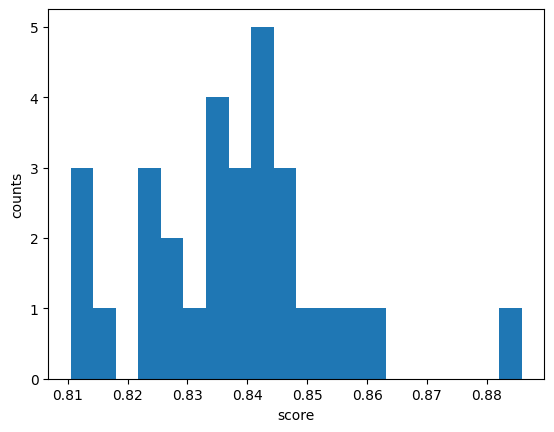

In [30]:
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

## BLEU, ROUGE, METEOR

In [34]:
# Calculate the metrics
bleu_scores, rouge_scores, meteor_scores = calculate_metrics(gptLargeTxt, chatGpt)
score_ = calculate_mean_scores(bleu_scores, rouge_scores, meteor_scores)
print(score_)

{'bleu': 0.5937963913121962, 'meteor': 0.18991858242120724, 'rouge-1': {'recall': 0.4688710483989122, 'precision': 0.08246424579573919, 'fmeasure': 0.13079793326165298}, 'rouge-2': {'recall': 0.1520562547001166, 'precision': 0.02049722662919527, 'fmeasure': 0.030218672991795002}, 'rouge-l': {'recall': 0.4435732171451986, 'precision': 0.07851965538149276, 'fmeasure': 0.1240431321934892}}


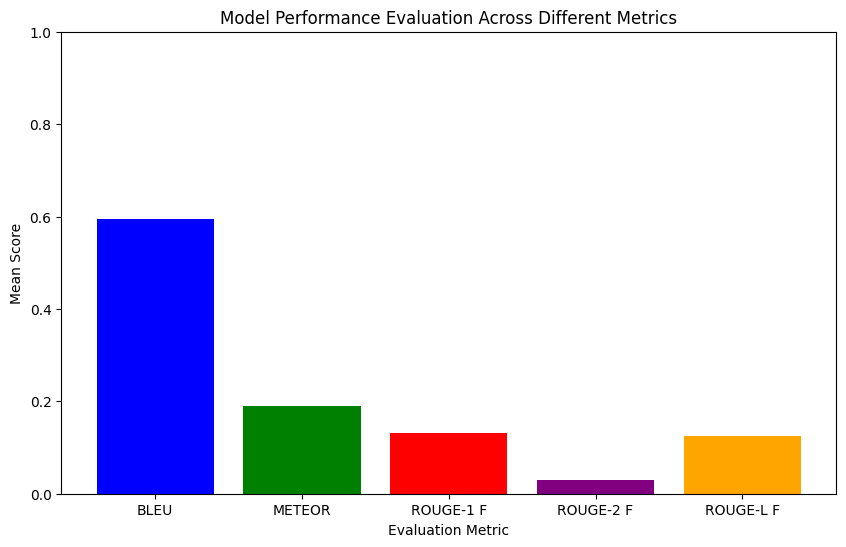

In [35]:
visualize_mean_scores(score_)

# Without LoRA Model V1

## BERTScore

In [36]:
# Calculer le BERTScore
P, R, F1 = score(withoutLoRAModel, chatGpt, lang='en', verbose=True)

# Afficher les scores
print(f'Précision moyenne: {P.mean().item():.6f}')
print(f'Recall moyen: {R.mean().item():.6f}')
print(f'Score F1 moyen: {F1.mean().item():.6f}')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.91 seconds, 32.85 sentences/sec
Précision moyenne: 0.833286
Recall moyen: 0.886777
Score F1 moyen: 0.858734


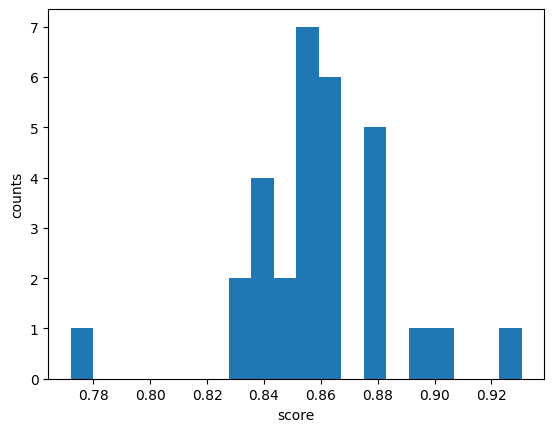

In [37]:
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

## BLEU, ROUGE, METEOR

In [38]:
# Calculate the metrics
bleu_scores, rouge_scores, meteor_scores = calculate_metrics(withoutLoRAModel, chatGpt)
score_ = calculate_mean_scores(bleu_scores, rouge_scores, meteor_scores)
print(score_)

{'bleu': 0.7862765106102951, 'meteor': 0.2716036902306755, 'rouge-1': {'recall': 0.32711792335631346, 'precision': 0.1272670582424279, 'fmeasure': 0.17618151164538023}, 'rouge-2': {'recall': 0.08047945542191066, 'precision': 0.024255081306221293, 'fmeasure': 0.03577787636598921}, 'rouge-l': {'recall': 0.29266469827615343, 'precision': 0.11390759876439116, 'fmeasure': 0.15766322216131062}}


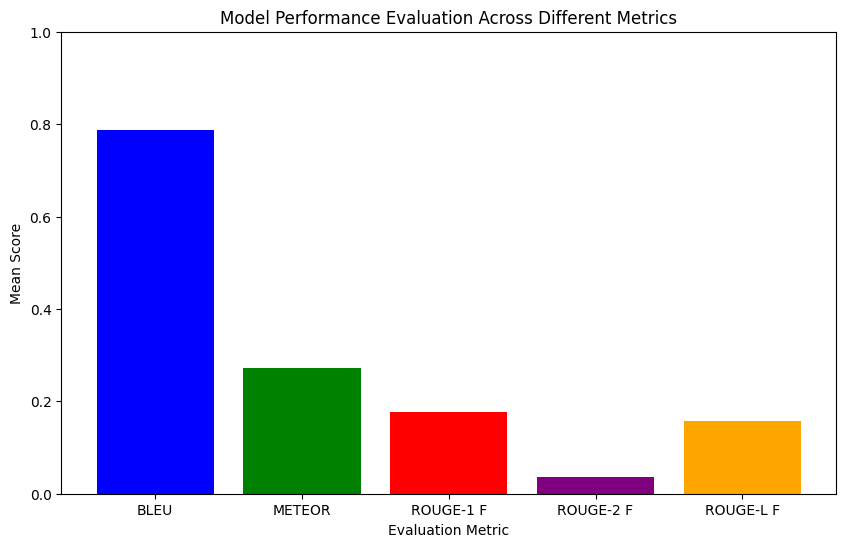

In [39]:
visualize_mean_scores(score_)

#LoRA Model V1

## BERTScore

In [40]:
# Calculer le BERTScore
P, R, F1 = score(loRAModelV1, chatGpt, lang='en', verbose=True)

# Afficher les scores
print(f'Précision moyenne: {P.mean().item():.6f}')
print(f'Recall moyen: {R.mean().item():.6f}')
print(f'Score F1 moyen: {F1.mean().item():.6f}')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.01 seconds, 29.77 sentences/sec
Précision moyenne: 0.825941
Recall moyen: 0.889692
Score F1 moyen: 0.856288


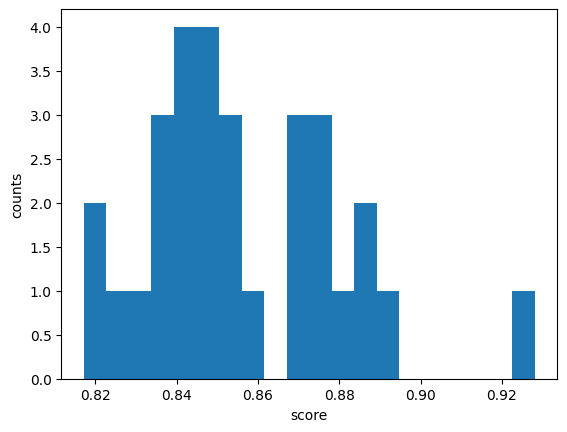

In [41]:
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

## BLEU, ROUGE, METEOR

In [42]:
# Calculate the metrics
bleu_scores, rouge_scores, meteor_scores = calculate_metrics(loRAModelV1, chatGpt)
score_ = calculate_mean_scores(bleu_scores, rouge_scores, meteor_scores)
print(score_)

{'bleu': 1.361595367612323, 'meteor': 0.2733694511063194, 'rouge-1': {'recall': 0.36484991158365776, 'precision': 0.13792262365151955, 'fmeasure': 0.19045514062471505}, 'rouge-2': {'recall': 0.1011052194939663, 'precision': 0.03788547037968503, 'fmeasure': 0.049562734421682283}, 'rouge-l': {'recall': 0.31473740970645, 'precision': 0.11927788617723609, 'fmeasure': 0.1639380149640353}}


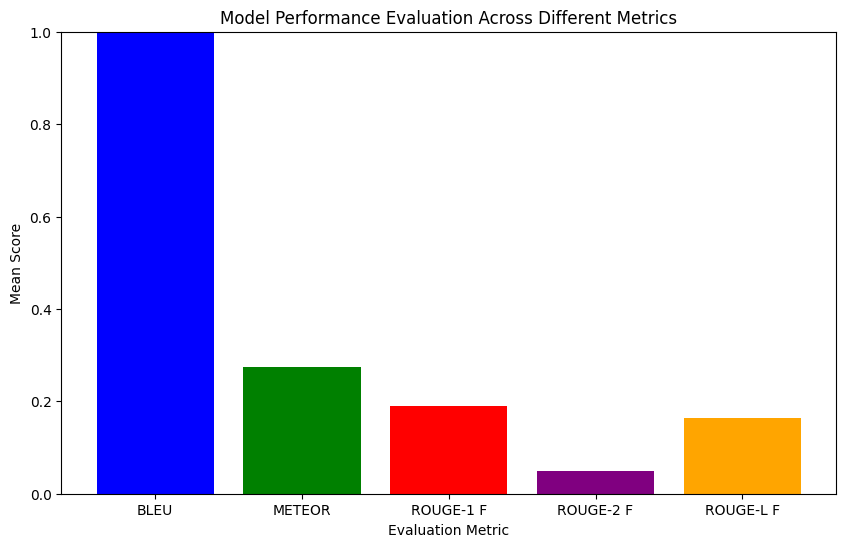

In [43]:
visualize_mean_scores(score_)

#LoRA Model V2

## BERTScore

In [44]:
# Calculer le BERTScore
P, R, F1 = score(loRAModelV2, chatGpt, lang='en', verbose=True)

# Afficher les scores
print(f'Précision moyenne: {P.mean().item():.6f}')
print(f'Recall moyen: {R.mean().item():.6f}')
print(f'Score F1 moyen: {F1.mean().item():.6f}')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.94 seconds, 31.87 sentences/sec
Précision moyenne: 0.838493
Recall moyen: 0.891159
Score F1 moyen: 0.863746


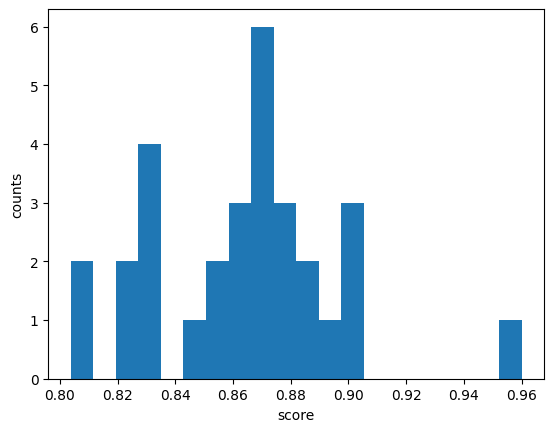

In [45]:
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

## BLEU, ROUGE, METEOR

In [46]:
# Calculate the metrics
bleu_scores, rouge_scores, meteor_scores = calculate_metrics(loRAModelV2, chatGpt)
score_ = calculate_mean_scores(bleu_scores, rouge_scores, meteor_scores)
print(score_)

{'bleu': 1.0179135667365242, 'meteor': 0.26764391877828436, 'rouge-1': {'recall': 0.3685656199665488, 'precision': 0.14246545570859506, 'fmeasure': 0.19544328310511164}, 'rouge-2': {'recall': 0.08878711028007703, 'precision': 0.027411748869432383, 'fmeasure': 0.03922364571581665}, 'rouge-l': {'recall': 0.33768155577366105, 'precision': 0.12666521214236687, 'fmeasure': 0.17621051164948373}}


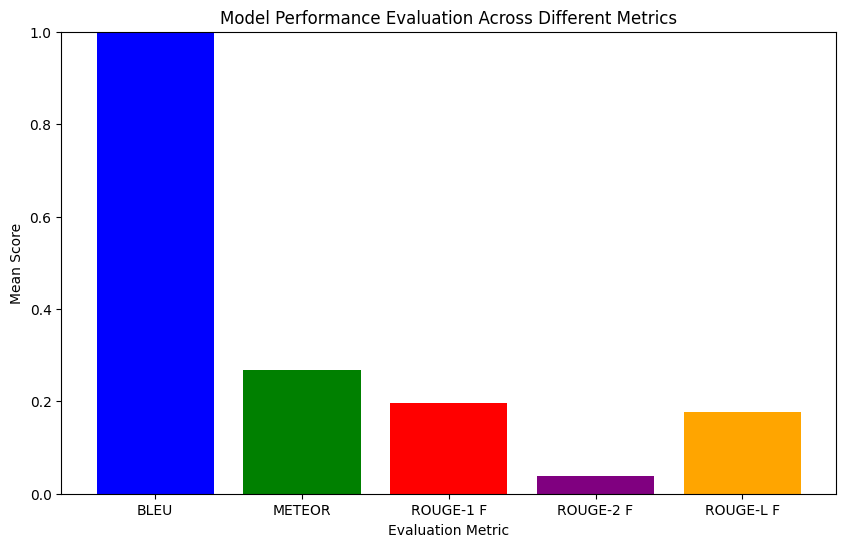

In [47]:
visualize_mean_scores(score_)

# Lora CP3


## BERTScore

In [48]:
# Calculer le BERTScore
P, R, F1 = score(loraCP3, chatGpt, lang='en', verbose=True)

# Afficher les scores
print(f'Précision moyenne: {P.mean().item():.6f}')
print(f'Recall moyen: {R.mean().item():.6f}')
print(f'Score F1 moyen: {F1.mean().item():.6f}')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.93 seconds, 32.18 sentences/sec
Précision moyenne: 0.810917
Recall moyen: 0.891658
Score F1 moyen: 0.848886


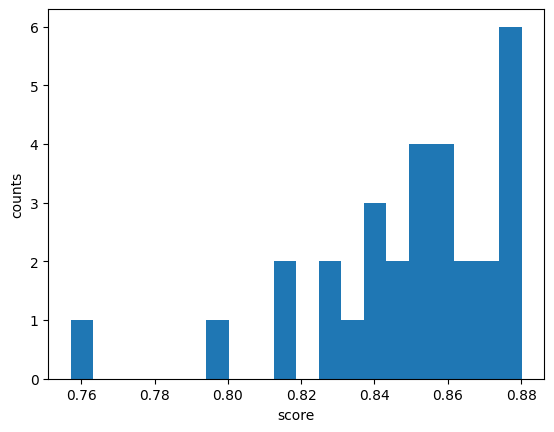

In [49]:
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

## BLEU, ROUGE, METEOR

In [50]:
# Calculate the metrics
bleu_scores, rouge_scores, meteor_scores = calculate_metrics(loraCP3, chatGpt)
score_ = calculate_mean_scores(bleu_scores, rouge_scores, meteor_scores)
print(score_)

{'bleu': 1.7751848342884282, 'meteor': 0.2833957476575995, 'rouge-1': {'recall': 0.370986479264343, 'precision': 0.1274184171985539, 'fmeasure': 0.18593088111916659}, 'rouge-2': {'recall': 0.14153465708772614, 'precision': 0.03690571264451649, 'fmeasure': 0.057222017213641875}, 'rouge-l': {'recall': 0.3555007395138974, 'precision': 0.12111823651526542, 'fmeasure': 0.1770553248027721}}


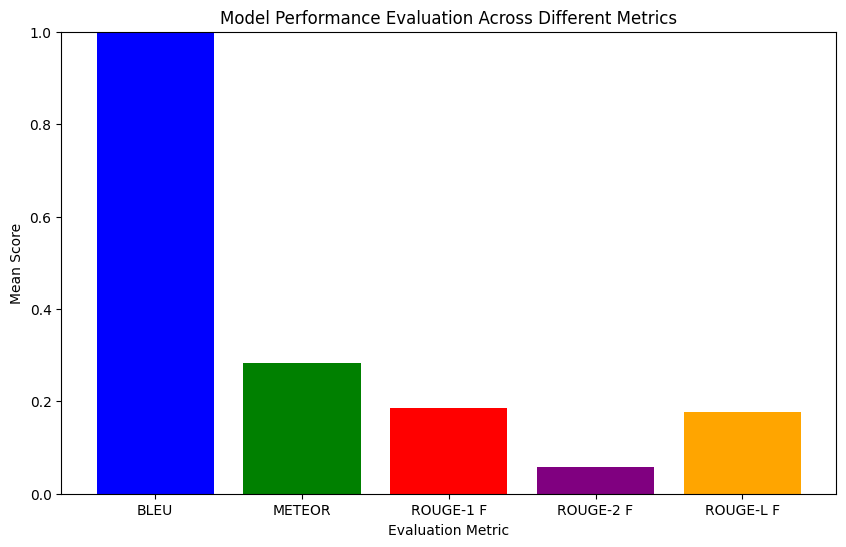

In [51]:
visualize_mean_scores(score_)